In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import sacpy.Map 
import sacpy as scp
import numpy as np
from matplotlib.ticker import MultipleLocator


In [3]:
data_path = "../../DATA/"
sst0 = xr.open_dataset(data_path + "HadISST_sst_2x2.nc")['sst']
uwind0 = xr.open_dataset(data_path + "ncep2_180x90/uwnd.10m.mon.mean.nc")['uwnd']
vwind0 = xr.open_dataset(data_path + "ncep2_180x90/vwnd.10m.mon.mean.nc")['vwnd']

time1 = "1980-01"
time2 = "2018-12"

def region_anom(data):
    if len(data.dims) == 4: 
        data = data.loc[time1:time2,10,-30:30,120:280]
    else:
        data = data.loc[time1:time2,-30:30,120:280]
    dataa = scp.get_anom(data,method=0)
    return dataa

ssta,ua,va = map(region_anom,[sst0,uwind0,vwind0])

In [4]:
# EOF

ssta_eof = ssta.loc[:,-20:30,150:275] # 95 
Eof = scp.EOF(ssta_eof)
Eof.solve()
pts = Eof.get_pt(npt=2)
pcs = Eof.get_pc(npt=2,)
pcs = -xr.DataArray(pcs,coords={"n":[0,1],"time":ssta_eof.time})
# pcs[1].plot()

In [5]:
def LinReg(pc):
    sst = scp.LinReg(pc,ssta).slope
    u = scp.LinReg(pc,ua).slope
    v = scp.LinReg(pc,va).slope
    return sst,u,v

res = [LinReg(pcs.loc[i]) for i in range(2)]
# res[0][0].plot()

In [6]:
# 
pmm_region_xr = res[1][0].copy()
pmm_region_xr = pmm_region_xr  > 0.17
pmm_region_xr [pmm_region_xr.lat<=5] = False 
pmm_region_xr[pmm_region_xr.lat==29] = False
# pmm_region_xr.plot()

In [7]:
pcs_var = pcs.groupby("time.season").var().reindex(season=np.array(['DJF', 'MAM', 'JJA', 'SON']))

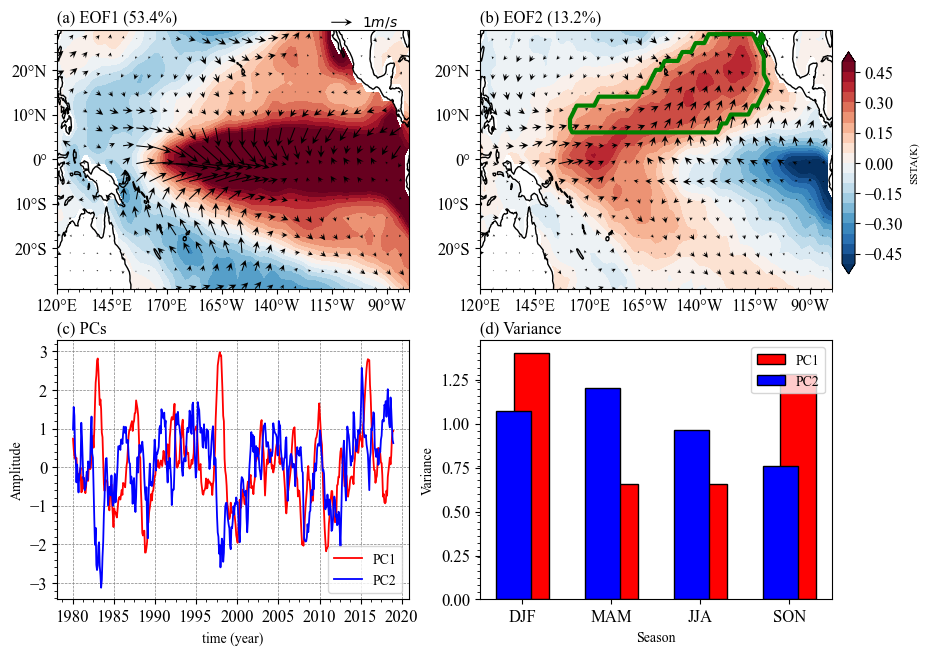

In [8]:
plt.rc('xtick', labelsize=12) #fontsize of the x tick labels
plt.rc('ytick', labelsize=12) #fontsize of the y tick labels
fig = plt.figure(figsize=(10, 7.4))
title_fontsize = 12
lon = ssta.lon
lat = ssta.lat
hw = 7
hl = 7
stepx = 3
stepy = 2
scale = 17
ax0 = fig.add_subplot(2, 2, 1, projection=ccrs.PlateCarree(central_longitude=180))
m = ax0.scontourf(lon, lat, res[0][0], cmap="RdBu_r",
                 levels=np.arange(-0.50, 0.51, 0.05), extend="both")

# stepx = 5
# stepy = 3
Q = ax0.squiver(lon,lat,res[0][1],res[0][2],transform=ccrs.PlateCarree(),headwidth=hw,headlength=hl,
               scale=scale,stepx=stepx,stepy=stepy)
ax0.quiverkey(Q, 0.42, 0.89, 1, r'$1 {m}/{s}$', labelpos='E',
              coordinates='figure')

ax0.init_map()
ax0.set_title("(a) EOF1 (53.4%)", loc="left",fontsize=title_fontsize)
################################################################################################################
#
# EOF2
#
################################################################################################################
ax1 = fig.add_subplot(2, 2, 2, projection=ccrs.PlateCarree(central_longitude=180))
m = ax1.scontourf(lon, lat, res[1][0],cmap="RdBu_r",
                 levels=np.arange(-0.50, 0.51, 0.05), extend="both")

levels=np.arange(-0.50, 0.51, 0.05)

Q = ax1.squiver(lon, lat, res[1][1], res[1][2],stepx=stepx,stepy=stepy,scale=scale,headwidth=hw,headlength=hl)
ax1.scontour(pmm_region_xr.lon,pmm_region_xr.lat,pmm_region_xr,levels=[0.5],colors="green",linewidths=3)
ax1.init_map()
ax1.set_title("(b) EOF2 (13.2%)", loc="left",fontsize=title_fontsize)
################################################################################################################
#
# 2 PCS  STD Bar
#
################################################################################################################

ax2 = fig.add_subplot(2, 2, 4)
ax2.bar(np.arange(4), pcs_var[0], width=0.4, label="PC1", color="red",edgecolor="black")
ax2.bar(np.arange(4) - 0.2, pcs_var[1], width=0.4, label="PC2", color="blue",edgecolor="black")
ax2.yaxis.set_minor_locator(MultipleLocator(0.04))
ax2.set_xticks(np.arange(4) - 0.1)
ax2.set_xticklabels(['DJF', 'MAM', 'JJA', 'SON'])
ax2.set_xlabel("Season")
ax2.set_ylabel("Variance")
ax2.set_title("(d) Variance", loc="left",fontsize=title_fontsize)
ax2.legend()

################################################################################################################
#
# 2 PCS  Time Series
#
################################################################################################################
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(pcs.time, pcs[0], linestyle="-", color="red", linewidth=1.3, label="PC1")
ax3.plot(pcs.time, pcs[1], linestyle="-", color="blue", linewidth=1.3, label="PC2")
ax3.minorticks_on()
ax3.set_xlabel("time (year)")
ax3.legend()
ax3.grid(linestyle='--', linewidth=0.5, color='gray')
ax3.set_title("(c) PCs", loc="left",fontsize=title_fontsize)
ax3.set_ylabel("Amplitude")
################################################################################################################
#
# ColorBar
#
################################################################################################################
ax_cb = fig.add_axes([0.91,0.55,0.013,0.3])
cb = fig.colorbar(m,cax=ax_cb,orientation="vertical", spacing="proportional")
cb.set_label("SSTA(K)",fontsize=8)
# plt.tight_layout()
################################################################################################################
#
# savefig
#
################################################################################################################
plt.savefig("./pic/Fig1.png",dpi=300)